In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
# define the dataset location
filename = "C:/Users/user/Downloads/mammography.csv.txt"
# load the csv file as a data frame
dataframe = pd.read_csv(filename, header=None)

In [5]:
dataframe.head()

,0,1,2,3,4,5,6
0,0.230020,5.072578,-0.276061,0.832444,-0.377866,0.480322,'-1'
1,0.155491,-0.169390,0.670652,-0.859553,-0.377866,-0.945723,'-1'
2,-0.784415,-0.443654,5.674705,-0.859553,-0.377866,-0.945723,'-1'
3,0.546088,0.131415,-0.456387,-0.859553,-0.377866,-0.945723,'-1'
4,-0.102987,-0.394994,-0.140816,0.979703,-0.377866,1.013566,'-1'


In [6]:
# summarize the shape of the dataset
print(dataframe.shape)

(11183, 7)


In [7]:
from collections import Counter
target = dataframe.values[:,-1]
counter = Counter(target)
for k,v in counter.items():
	per = v / len(target) * 100
	print('Class=%s, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class='-1', Count=10923, Percentage=97.675%
Class='1', Count=260, Percentage=2.325%


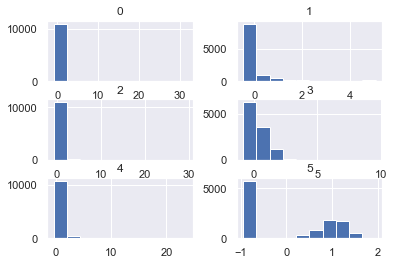

In [9]:
# histograms of all variables
dataframe.hist()
plt.show()

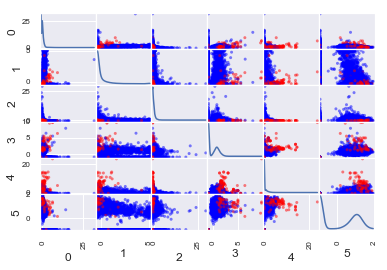

In [17]:
from pandas.plotting import scatter_matrix
# define a mapping of class values to colors
color_dict = {"'-1'":'blue', "'1'":'red'}
# map each row to a color based on the class value
colors = [color_dict[str(x)] for x in dataframe.values[:, -1]]
# pairwise scatter plots of all numerical variables
from pandas.plotting import scatter_matrix
scatter_matrix(dataframe, diagonal='kde', color=colors)
plt.show()

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.dummy import DummyClassifier
# load the dataset
def load_dataset(full_path):
	# load the dataset as a numpy array
	data = pd.read_csv(full_path, header=None)
	# retrieve numpy array
	data = data.values
	# split into input and output elements
	X, y = data[:, :-1], data[:, -1]
	# label encode the target variable to have the classes 0 and 1
	y = LabelEncoder().fit_transform(y)
	return X, y

In [21]:
# evaluate a model
def evaluate_model(X, y, model):
	# define evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
	return scores

In [22]:
# define the location of the dataset
full_path = filename
# load the dataset
X, y = load_dataset(full_path)
# summarize the loaded dataset
print(X.shape, y.shape, Counter(y))
# define the reference model

(11183, 6) (11183,) Counter({0: 10923, 1: 260})


In [23]:
# define the reference model
model = DummyClassifier(strategy='stratified')
# evaluate the model
scores = evaluate_model(X, y, model)
# summarize performance
print('Mean ROC AUC: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean ROC AUC: 0.501 (0.015)


>LR 0.919 (0.040)
>SVM 0.880 (0.049)
>BAG 0.941 (0.039)
>RF 0.951 (0.034)
>GBM 0.918 (0.037)


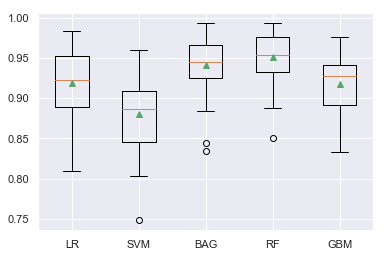

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
 

# define models to test
def get_models():
	models, names = list(), list()
	# LR
	models.append(LogisticRegression(solver='lbfgs'))
	names.append('LR')
	# SVM
	models.append(SVC(gamma='scale'))
	names.append('SVM')
	# Bagging
	models.append(BaggingClassifier(n_estimators=1000))
	names.append('BAG')
	# RF
	models.append(RandomForestClassifier(n_estimators=1000))
	names.append('RF')
	# GBM
	models.append(GradientBoostingClassifier(n_estimators=1000))
	names.append('GBM')
	return models, names
 
# define the location of the dataset
full_path = filename
# load the dataset
X, y = load_dataset(full_path)
# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
	# evaluate the model and store results
	scores = evaluate_model(X, y, models[i])
	results.append(scores)
	# summarize and store
	print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))
# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

>LR 0.923 (0.037)
>SVM 0.957 (0.024)
>RF 0.951 (0.038)


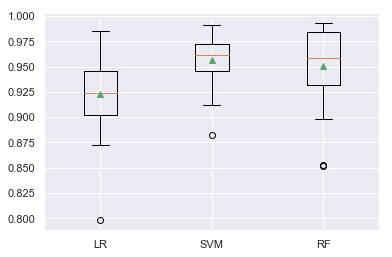

In [27]:
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
# define models to test
def get_models():
	models, names = list(), list()
	# LR
	models.append(LogisticRegression(solver='lbfgs', class_weight='balanced'))
	names.append('LR')
	# SVM
	models.append(SVC(gamma='scale', class_weight='balanced'))
	names.append('SVM')
	# RF
	models.append(RandomForestClassifier(n_estimators=1000))
	names.append('RF')
	return models, names
 
# define the location of the dataset
full_path = filename
# load the dataset
X, y = load_dataset(full_path)
# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
	# defines pipeline steps
	steps = [('p', PowerTransformer()), ('m',models[i])]
	# define pipeline
	pipeline = Pipeline(steps=steps)
	# evaluate the pipeline and store results
	scores = evaluate_model(X, y, pipeline)
	results.append(scores)
	# summarize and store
	print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))
# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

Make Predictions on New Data
In this section, we will fit a final model and use it to make predictions on single rows of data

We will use the cost-sensitive version of the SVM model as the final model and a power transform on the data prior to fitting the model and making a prediction. Using the pipeline will ensure that the transform is always performed correctly on input data.

In [29]:
# load the dataset
def load_dataset(full_path):
	# load the dataset as a numpy array
	data = pd.read_csv(full_path, header=None)
	# retrieve numpy array
	data = data.values
	# split into input and output elements
	X, y = data[:, :-1], data[:, -1]
	# label encode the target variable to have the classes 0 and 1
	y = LabelEncoder().fit_transform(y)
	return X, y
 
# define the location of the dataset
full_path = filename
# load the dataset
X, y = load_dataset(full_path)
# define model to evaluate
model = SVC(gamma='scale', class_weight='balanced')
# power transform then fit model
pipeline = Pipeline(steps=[('t',PowerTransformer()), ('m',model)])
# fit the model
pipeline.fit(X, y)
# evaluate on some no cancer cases (known class 0)
print('No Cancer:')
data = [[0.23001961,5.0725783,-0.27606055,0.83244412,-0.37786573,0.4803223],
	[0.15549112,-0.16939038,0.67065219,-0.85955255,-0.37786573,-0.94572324],
	[-0.78441482,-0.44365372,5.6747053,-0.85955255,-0.37786573,-0.94572324]]
for row in data:
	# make prediction
	yhat = pipeline.predict([row])
	# get the label
	label = yhat[0]
	# summarize
	print('>Predicted=%d (expected 0)' % (label))
# evaluate on some cancer (known class 1)
print('Cancer:')
data = [[2.0158239,0.15353258,-0.32114211,2.1923706,-0.37786573,0.96176503],
	[2.3191888,0.72860087,-0.50146835,-0.85955255,-0.37786573,-0.94572324],
	[0.19224721,-0.2003556,-0.230979,1.2003796,2.2620867,1.132403]]
for row in data:
	# make prediction
	yhat = pipeline.predict([row])
	# get the label
	label = yhat[0]
	# summarize
	print('>Predicted=%d (expected 1)' % (label))


No Cancer:
>Predicted=0 (expected 0)
>Predicted=0 (expected 0)
>Predicted=0 (expected 0)
Cancer:
>Predicted=1 (expected 1)
>Predicted=1 (expected 1)
>Predicted=1 (expected 1)
